Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

Load dataset and prepare df. Keeping only those columns, that are not directly computed out of new deaths, and have the highest correlation

In [2]:
file_path = './data/owid-covid-data.csv'
date_column = 'date'
target_column = 'new_deaths'
df = pd.read_csv(file_path, parse_dates=[date_column])
len(set(df['iso_code'].values))

255

In [3]:
# Load the dfset
file_path = './data/WHO-COVID-19-global-data.csv'
date_column = 'Date_reported'
target_column = 'New_deaths'
df = pd.read_csv(file_path, parse_dates=[date_column])
date = df[date_column]
df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
# df = df.select_dtypes(exclude=['object'])
correlation_with_target = df.select_dtypes(exclude=['object']).drop(columns=[target_column]).corrwith(df[target_column])
most_corr = correlation_with_target.sort_values(ascending=False).index.tolist()
most_corr = list(set(most_corr[:10] + most_corr[-10:]))
df = df[most_corr].merge(df[target_column], left_index=True, right_index=True)
most_corr

['Cumulative_deaths', 'New_cases', 'Cumulative_cases']

Plot the dataset

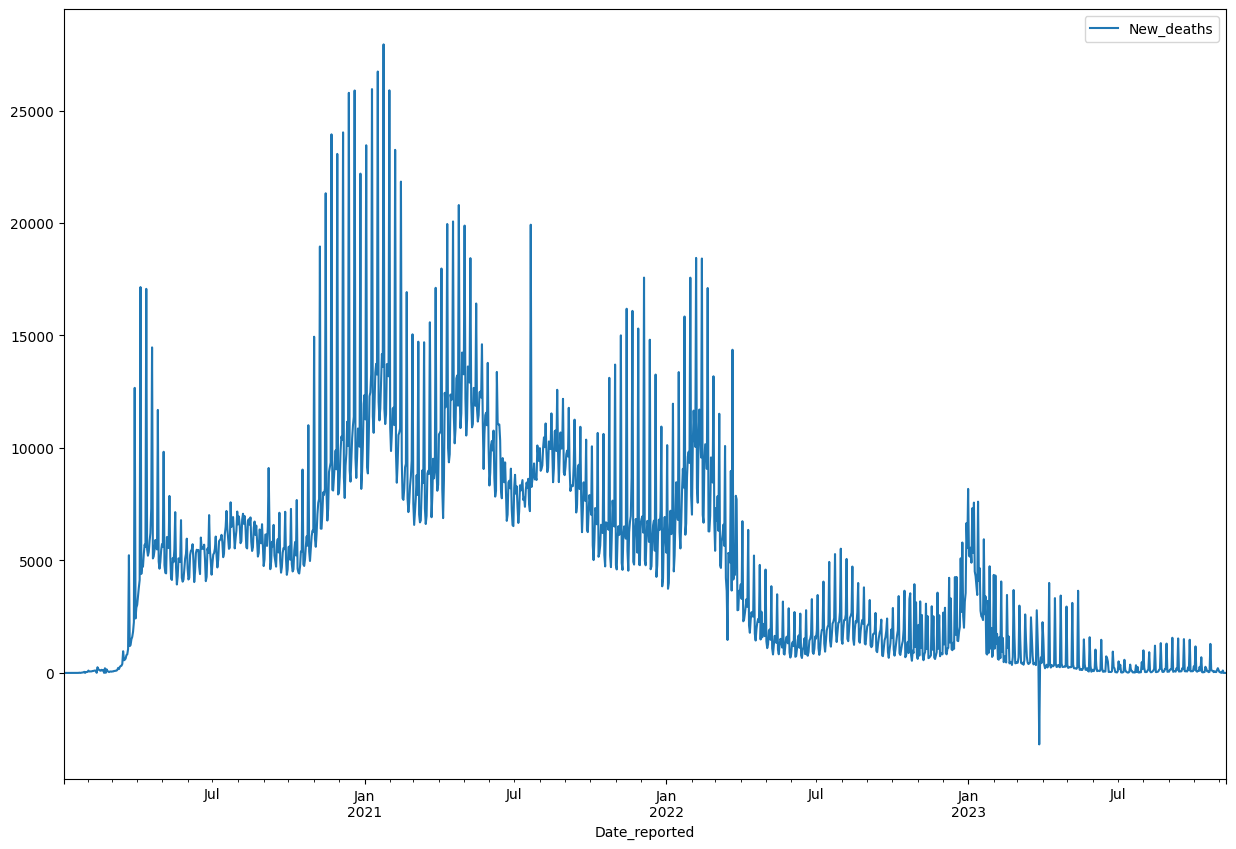

In [4]:
plot_cols = [target_column]
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(15, 10))


Display first values

In [5]:
df.head()


,Cumulative_deaths,New_cases,Cumulative_cases,New_deaths
Date_reported,,,,
2020-01-03,0,0,0,0
2020-01-04,0,3,3,0
2020-01-05,3,-1,2,3
2020-01-06,3,3,5,0
2020-01-07,3,0,5,0


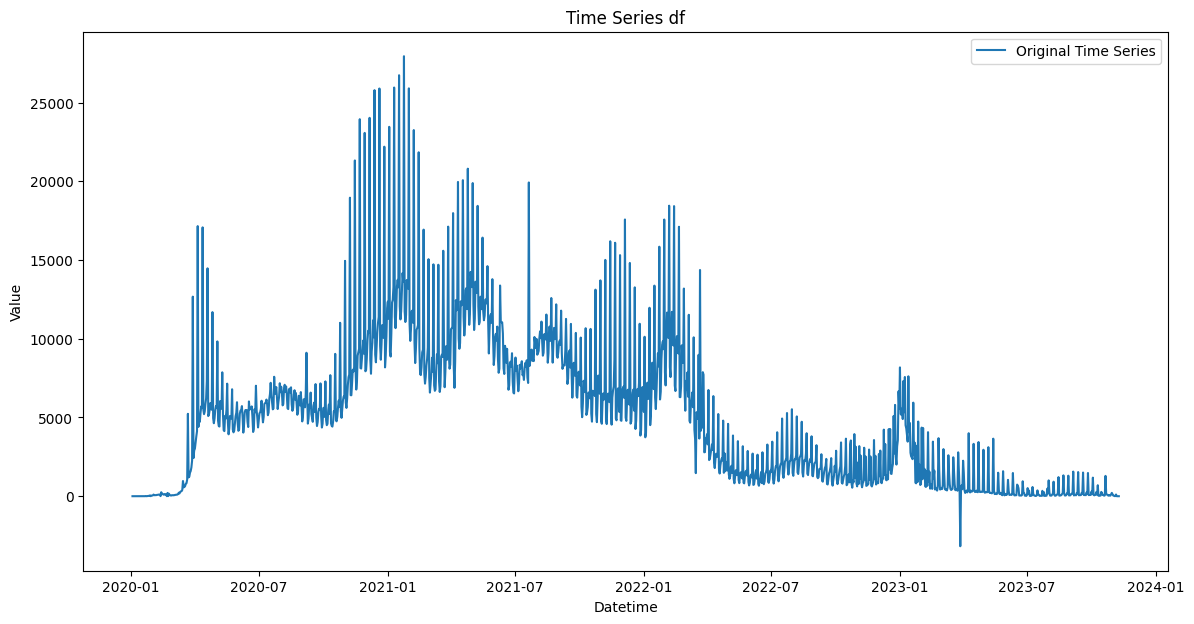

In [6]:
# Plot the entire time series df
plt.figure(figsize=(14, 7))
plt.plot(df[target_column], label='Original Time Series')
plt.title('Time Series df')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.show()


Decompose the time series into trend, seasonal, and residual components

In [7]:
decomposition = seasonal_decompose(
    df[target_column], model='aditive', period=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


Plot the original time series, trend, seasonal, and residual components

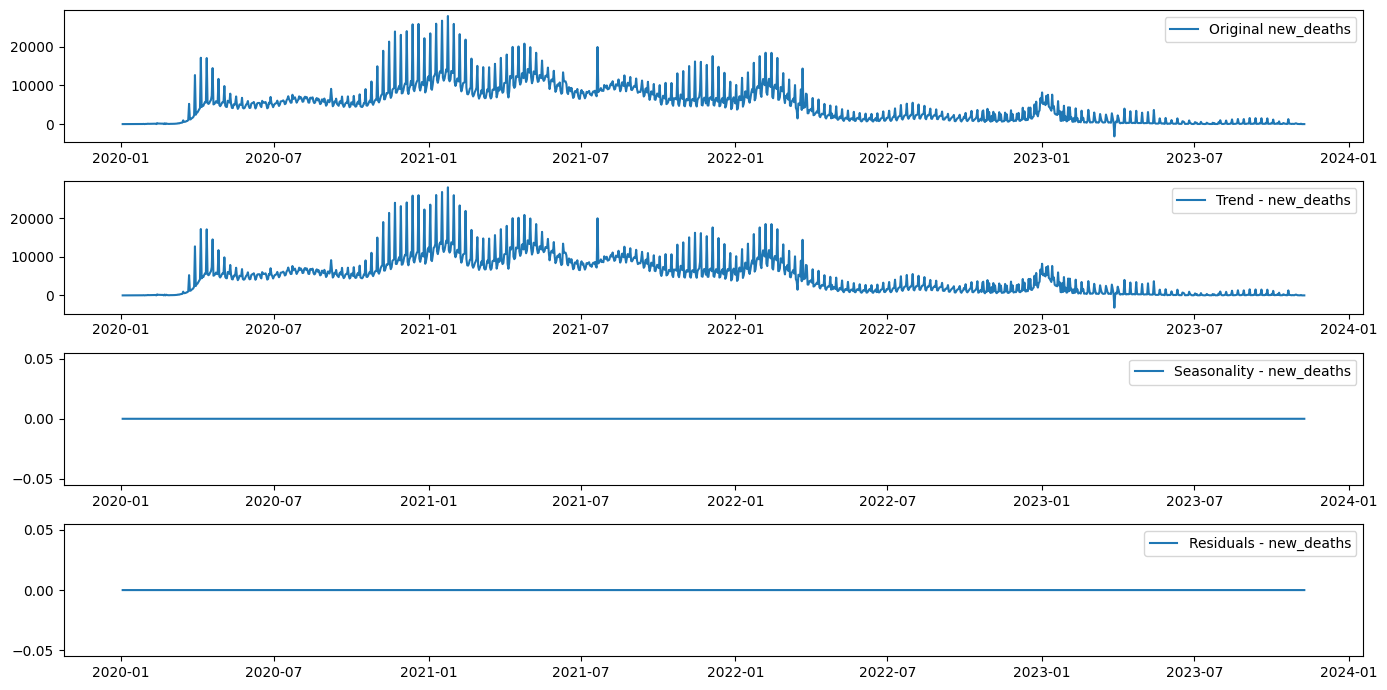

count     1407.000000
mean      4959.612651
std       4644.190584
min      -3176.000000
25%        836.000000
50%       4634.000000
75%       7758.000000
max      27939.000000
Name: New_deaths, dtype: float64


In [8]:
plt.figure(figsize=(14, 7))

plt.subplot(411)
plt.plot(df[target_column], label=f'Original new_deaths')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label=f'Trend - new_deaths')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label=f'Seasonality - new_deaths')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label=f'Residuals - new_deaths')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Display summary statistics for the current target_column
print(df[target_column].describe())


Plot ACF and PACF

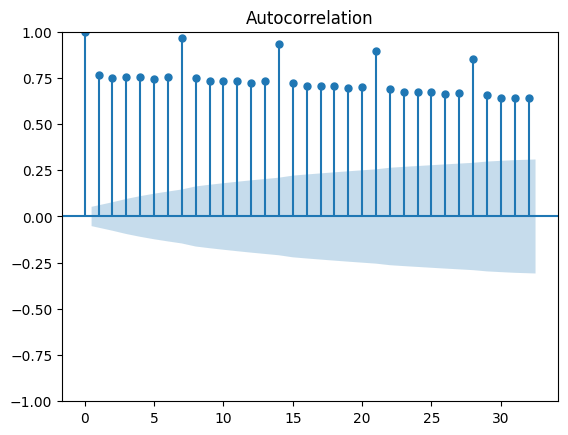

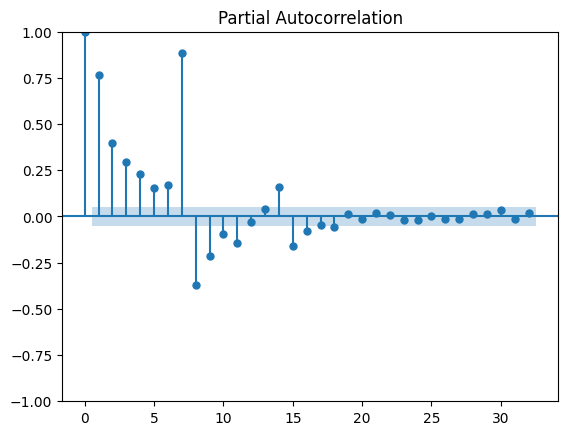

In [9]:
plot_acf(df[[target_column]])
plt.show()

plot_pacf(df[[target_column]])
plt.show()

Determine whether the dataset is stationary

In [10]:
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(df[target_column])

1. ADF :  -2.1134171180648744
2. P-Value :  0.23915384830229824
3. Num Of Lags :  17
4. Num Of Observations Used For ADF Regression: 1389
5. Critical Values :
	 1% :  -3.4350666494778137
	 5% :  -2.8636230590277587
	 10% :  -2.5678790153478865


In [11]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df)
profile.to_file('profile_report.html')


/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/samuell/.local/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/samuell/.local/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecat

In [12]:
import whylogs as why

profile = why.log(df).profile()

⚠️ No session found. Call whylogs.init() to initialize a session and authenticate. See https://docs.whylabs.ai/docs/whylabs-whylogs-init for more information.


In [13]:
from whylogs.api.fugue import fugue_profile

fugue_profile(df).to_pandas()

ModuleNotFoundError: No module named 'fugue'